In [17]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
df=pd.read_csv('healthcare.csv')

In [18]:
#As there are a lot of null data, i drop them.
df.dropna()

,Year,Sex,Type,Cancer_Type,Age_0_to_4,Age_5_to_9,Age_10_to_14,Age_15_to_19,Age_20_to_24,Age_25_to_29,...,Age_45_to_49,Age_50_to_54,Age_55_to_59,Age_60_to_64,Age_65_to_69,Age_70_to_74,Age_75_to_79,Age_80_to_84,Age_85+,Age_Unknown
14,1982,Male,Incidence,Acute lymphoblastic leukaemia,42.0,25.0,14.0,14.0,5.0,2.0,...,0.0,0.0,1.0,7.0,2.0,3.0,4.0,1.0,0.0,0.0
15,1983,Male,Incidence,Acute lymphoblastic leukaemia,41.0,18.0,11.0,4.0,6.0,5.0,...,1.0,2.0,0.0,0.0,3.0,2.0,5.0,6.0,2.0,0.0
16,1984,Male,Incidence,Acute lymphoblastic leukaemia,49.0,18.0,10.0,10.0,8.0,1.0,...,3.0,1.0,4.0,6.0,2.0,4.0,2.0,2.0,1.0,0.0
17,1985,Male,Incidence,Acute lymphoblastic leukaemia,59.0,17.0,15.0,13.0,7.0,2.0,...,2.0,4.0,4.0,3.0,7.0,3.0,4.0,1.0,0.0,0.0
18,1986,Male,Incidence,Acute lymphoblastic leukaemia,43.0,17.0,13.0,10.0,8.0,5.0,...,1.0,2.0,2.0,6.0,8.0,5.0,5.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9191,2007,Female,Mortality,Uterine cancer,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,11.0,26.0,35.0,34.0,47.0,54.0,48.0,73.0,0.0
9192,2008,Female,Mortality,Uterine cancer,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,11.0,23.0,43.0,43.0,50.0,39.0,63.0,63.0,0.0
9193,2009,Female,Mortality,Uterine cancer,0.0,0.0,0.0,0.0,0.0,1.0,...,14.0,20.0,24.0,44.0,41.0,50.0,46.0,45.0,61.0,0.0
9194,2010,Female,Mortality,Uterine cancer,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,12.0,19.0,32.0,51.0,51.0,53.0,63.0,76.0,0.0


In [19]:
filtro = (df["Cancer_Type"] == "Uterine cancer") & (df["Type"] == "Mortality") 

uterine_df1= df[filtro]
uterine_df1=uterine_df1.dropna()

filtro = (df["Cancer_Type"] == "Uterine cancer") & (df["Type"] == "Incidence") 

uterine_df2= df[filtro]
uterine_df2=uterine_df2.dropna()

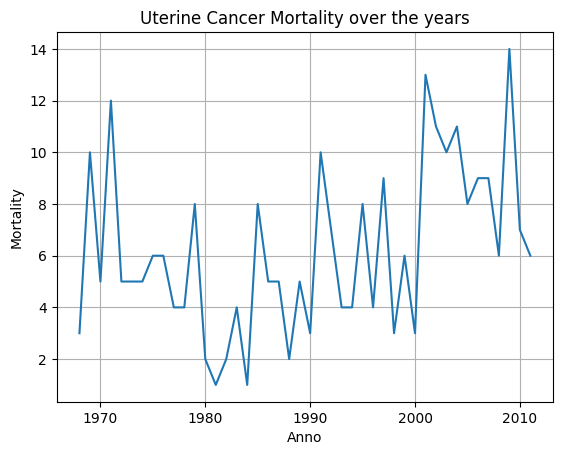

In [20]:
plt.plot(uterine_df1["Year"], uterine_df1['Age_45_to_49'])
plt.xlabel("Anno")
plt.ylabel("Mortality")
plt.title("Uterine Cancer Mortality over the years")
plt.grid(True)
plt.show()

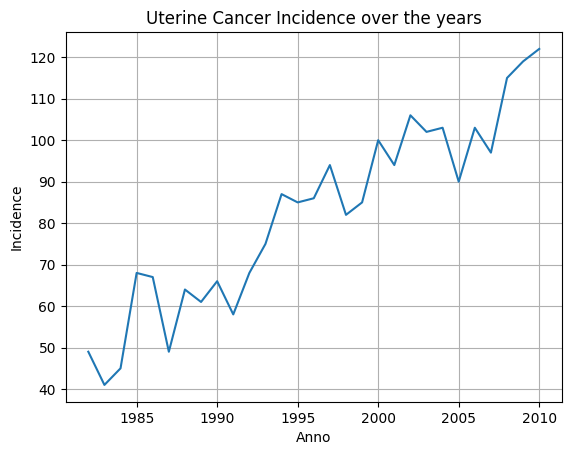

In [21]:
plt.plot(uterine_df2["Year"], uterine_df2['Age_45_to_49'])
plt.xlabel("Anno")
plt.ylabel("Incidence")
plt.title("Uterine Cancer Incidence over the years")
plt.grid(True)
plt.show()

In [22]:
uterine_df2

,Year,Sex,Type,Cancer_Type,Age_0_to_4,Age_5_to_9,Age_10_to_14,Age_15_to_19,Age_20_to_24,Age_25_to_29,...,Age_45_to_49,Age_50_to_54,Age_55_to_59,Age_60_to_64,Age_65_to_69,Age_70_to_74,Age_75_to_79,Age_80_to_84,Age_85+,Age_Unknown
9034,1982,Female,Incidence,Uterine cancer,0.0,0.0,0.0,0.0,3.0,5.0,...,49.0,99.0,149.0,168.0,140.0,115.0,80.0,46.0,33.0,0.0
9035,1983,Female,Incidence,Uterine cancer,0.0,1.0,0.0,0.0,1.0,3.0,...,41.0,102.0,143.0,139.0,138.0,119.0,87.0,58.0,35.0,0.0
9036,1984,Female,Incidence,Uterine cancer,0.0,0.0,0.0,0.0,1.0,2.0,...,45.0,98.0,159.0,187.0,168.0,124.0,79.0,43.0,39.0,0.0
9037,1985,Female,Incidence,Uterine cancer,0.0,0.0,0.0,3.0,1.0,3.0,...,68.0,100.0,147.0,164.0,147.0,146.0,89.0,53.0,50.0,1.0
9038,1986,Female,Incidence,Uterine cancer,0.0,0.0,0.0,0.0,1.0,2.0,...,67.0,109.0,142.0,184.0,180.0,126.0,102.0,58.0,47.0,0.0
9039,1987,Female,Incidence,Uterine cancer,0.0,0.0,0.0,1.0,1.0,0.0,...,49.0,111.0,134.0,189.0,173.0,162.0,96.0,52.0,44.0,0.0
9040,1988,Female,Incidence,Uterine cancer,0.0,0.0,0.0,0.0,0.0,1.0,...,64.0,111.0,144.0,176.0,173.0,130.0,109.0,59.0,41.0,0.0
9041,1989,Female,Incidence,Uterine cancer,0.0,0.0,0.0,0.0,0.0,3.0,...,61.0,105.0,141.0,174.0,165.0,131.0,97.0,57.0,46.0,0.0
9042,1990,Female,Incidence,Uterine cancer,0.0,0.0,0.0,0.0,2.0,0.0,...,66.0,90.0,138.0,169.0,159.0,170.0,109.0,72.0,48.0,0.0
9043,1991,Female,Incidence,Uterine cancer,0.0,0.0,0.0,1.0,0.0,2.0,...,58.0,106.0,135.0,179.0,204.0,168.0,126.0,84.0,45.0,0.0


In [23]:
#Now we want to evaluate incidence and mortality on the same graphic, so we need normalization. 
#I also sum cases for all ages
scaler=MinMaxScaler()
uterine_df1["Sum"] = uterine_df1.loc[:, "Age_0_to_4":"Age_Unknown"].sum(axis=1)
uterine_df1['Normalized_sum']=scaler.fit_transform(uterine_df1[['Sum']])

uterine_df2["Sum_Death"] = uterine_df2.loc[:, "Age_0_to_4":"Age_Unknown"].sum(axis=1)
uterine_df2['Normalized_sum_death']=scaler.fit_transform(uterine_df2[['Sum_Death']])

In [24]:
uterine_df1 = pd.merge(uterine_df1, uterine_df2[['Year', 'Sum_Death', 'Normalized_sum_death']], on='Year', how='inner')

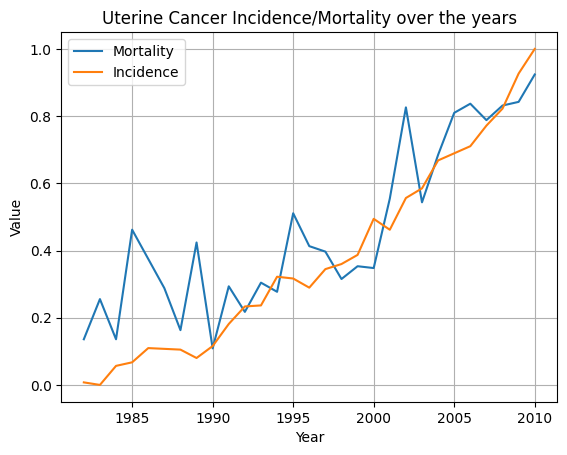

In [27]:
plt.plot(uterine_df1["Year"], uterine_df1['Normalized_sum'], label="Mortality")
plt.plot(uterine_df1["Year"], uterine_df1['Normalized_sum_death'], label="Incidence")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Value")
plt.title("Uterine Cancer Incidence/Mortality over the years")
plt.grid(True)
plt.show()


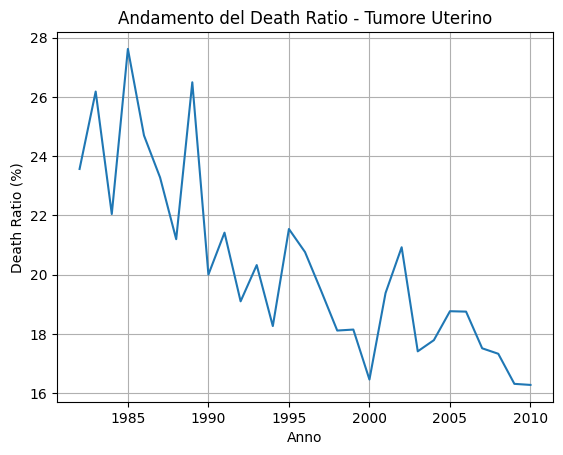

In [26]:
uterine_df1['Death_Ratio']=uterine_df1['Sum']/uterine_df1['Sum_Death']

# Creare il grafico
plt.plot(uterine_df1['Year'], uterine_df1['Death_Ratio']*100 )
plt.xlabel('Anno')
plt.ylabel('Death Ratio (%)')
plt.title('Andamento del Death Ratio - Tumore Uterino')
plt.grid(True)
plt.show()